<a href="https://colab.research.google.com/github/kanakesh2006/Langgraph_for_Agentic_AI_Concepts/blob/main/Persistence/fault_tolerence_crash_persistence__workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain langgraph langchain_community langchain_core transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
import operator
import time

In [3]:
# state

class CrashState(TypedDict):

  input: str
  step1: str
  step2: str
  step3: str

In [4]:
# steps

def step_1(state: CrashState) -> CrashState:
  print("step 1 executed")
  return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
  print("step 2 hanging... now manually interrupt from the notebook too bar (STOP) button")
  time.sleep(30)
  return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
  print("step 3 executed")
  return {"step3": "done"}


In [5]:
# graph
builder = StateGraph(CrashState)

# nodes
builder.add_node("step 1", step_1)
builder.add_node("step 2", step_2)
builder.add_node("step 3", step_3)

# edges
builder.add_edge(START, "step 1")
builder.add_edge("step 1", "step 2")
builder.add_edge("step 2", "step 3")
builder.add_edge("step 3", END)

# memory
checkpointer = InMemorySaver()

# compile
graph = builder.compile(checkpointer=checkpointer)

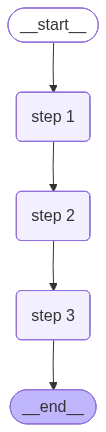

In [6]:
graph

In [7]:
try:
  print("Running graph: ")
  graph.invoke({"input":"start"}, config={"configurable": {"thread_id": "thread-1"}})
except KeyboardInterrupt:
  print(" ~~~ error :  Kernel manually interupted (crash simulated). ")

Running graph: 
step 1 executed
step 2 hanging... now manually interrupt from the notebook too bar (STOP) button
step 3 executed


In [8]:
graph.get_state({"configurable": {"thread_id": 'thread-1'}})

StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544e-64fb-8003-7d5df732b616'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-20T03:35:09.490251+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544a-6b2f-8002-bdcb0b93e721'}}, tasks=(), interrupts=())

In [9]:
list(graph.get_state_history({"configurable": {"thread_id": "thread-1"}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544e-64fb-8003-7d5df732b616'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-20T03:35:09.490251+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544a-6b2f-8002-bdcb0b93e721'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step 3',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544a-6b2f-8002-bdcb0b93e721'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-20T03:35:09.488791+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b0f-3623-6c90-8001-cb9ebb40d7e2'}}, tasks=(PregelTask(id='866a6570-902e-b8d0

In [10]:
graph.invoke(None, config={"configurable": {"thread_id": "thread-1"}})

{'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}

In [11]:
graph.get_state({"configurable": {"thread_id": 'thread-1'}})

StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544e-64fb-8003-7d5df732b616'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-20T03:35:09.490251+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544a-6b2f-8002-bdcb0b93e721'}}, tasks=(), interrupts=())

In [12]:
list(graph.get_state_history({"configurable": {"thread_id": "thread-1"}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544e-64fb-8003-7d5df732b616'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-20T03:35:09.490251+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544a-6b2f-8002-bdcb0b93e721'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step 3',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b10-544a-6b2f-8002-bdcb0b93e721'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-20T03:35:09.488791+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b0f-3623-6c90-8001-cb9ebb40d7e2'}}, tasks=(PregelTask(id='866a6570-902e-b8d0

## Time Travel to previous execution or state

In [14]:
graph.get_state({"configurable": {"thread_id": "thread-1", "checkpoint_id": '1f0f5b0f-3617-6d2f-bfff-0dd13d533b85'}})

StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_id': '1f0f5b0f-3617-6d2f-bfff-0dd13d533b85'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2026-01-20T03:34:39.478691+00:00', parent_config=None, tasks=(PregelTask(id='4d730147-7c1c-c9ee-dc11-1497619dfa44', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'input': 'start'}),), interrupts=())

In [17]:
graph.invoke(None, {"configurable": {"thread_id": "thread-1", "checkpoint_id": '1f0f5b0f-3617-6d2f-bfff-0dd13d533b85'}})

step 1 executed
step 2 hanging... now manually interrupt from the notebook too bar (STOP) button
step 3 executed


{'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}

In [20]:
len(list(graph.get_state_history({"configurable": {"thread_id": "thread-1"}})))

9

In [21]:
list(graph.get_state_history({"configurable": {"thread_id": "thread-1"}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b65-c8e0-6278-8003-0bab6df50f14'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-20T04:13:23.414875+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b65-c8dc-6666-8002-75562a5a60f4'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step 3',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b65-c8dc-6666-8002-75562a5a60f4'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-20T04:13:23.413328+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f5b64-aabf-61c5-8001-de7d4e774807'}}, tasks=(PregelTask(id='2c209a1a-9a70-ce0d

In [26]:
graph.update_state({"configurable": {"thread_id": "thread-1", 'checkpoint_id': '1f0f5b0f-3617-6d2f-bfff-0dd13d533b85', "checkpoint_ns": ""}}, values={"topic": "samosa"})

{'configurable': {'thread_id': 'thread-1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0f5b81-5bbc-66b2-8000-317c29aa75bd'}}

In [27]:
len(list(graph.get_state_history({"configurable": {"thread_id": "thread-1"}})))

10